Classifier for question 2

In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

import re
import math
import string
from collections import Counter
from __future__ import division
from time import time
import logging

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile

import itertools

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

from nltk import FreqDist
from nltk.stem import PorterStemmer
from string import punctuation

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#From scikit's examples
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

class_names = [1, 2, 3, 4, 5]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#read_file is a helper function to get the '|' delimited CSV into a data frame
def read_file(filename):
    #get the file
    df = pd.read_csv(filename, error_bad_lines=False, encoding = 'mbcs')
    
    #Force KIScore to int, otherwise reverts to float. Same for Answer. Forcing NaN to unicode
    df['KIScore'] = df['KIScore'].astype(int)
    df['Answer'] = df['Answer'].astype(str)
    # Filters if needed later on
    #filtered_data = df["Answer"].notnull()
    #filtered_data = df[df["KIScore"] != 1 & df['Answer'].notnull() & df["KIScore"].notnull()]
    #df_narrative = df[filtered_data]
    return df

#reads in the training data into a panda - Steve 
#(code based on ANLP Notebook Intro to Pandas by Marti Hearst and Andrea Gagliano)
def read_training_data(filename):
    df_narrative = read_file(filename)
    return df_narrative

In [4]:
#breaks the panda into a training set and a dev set - Currently only genereates dev and test data
#Modify the function later to keep some data as test data as well

def get_train_and_dev_sets(full_data, percent_dev):
    #randomize the indices
    random_index = np.random.permutation(full_data.index)
    full_data_shuffled = full_data.ix[random_index, ['WISEID', 'Answer', 'KIScore']]
    full_data_shuffled.reset_index(drop=True, inplace=True)
    
    #break down the counts for the shuffled data
    rows, columns = full_data_shuffled.shape
    train_size = round(rows*(1 - percent_dev))
    dev_size   = round(rows*percent_dev)
    
    #separate the training data from the development data
    train_data = full_data_shuffled.loc[:train_size]
    dev_data = full_data_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)

    return train_data, dev_data 

In [5]:
#reads in the test file into a panda
def read_test_data(filename):
    #get the file
    df = read_file(filename)
    return df

df = read_training_data("Laura1.csv")
train_set, dev_set = get_train_and_dev_sets(df,.2)

Norvig's spell checker

In [6]:
TEXT = open('big.txt').read()

def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower())

def tokens_target(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    words = re.findall('[a-z]+', text.lower())
    tagged_POS_sents = nltk.pos_tag(words) # tags sents
    #normed_tagged_words = [wnl.lemmatize(word[0].lower()) for sent in tagged_POS_sents
                           #for word in sent 
                           #if word[0].lower() not in nltk.corpus.stopwords.words('english')
                           #and word[0] not in punctuation # remove punctuation
                           #and not re.search(r'''^[\.,;"'?!():\-_`]+$''', word[0])
                           #and word[1].startswith('N')]  # include only nouns
    #print(tagged_POS_sents)
    return words
    if (len(tagged_POS_sents) > 1):
        normed_tagged_words = [word[0].lower() for word in tagged_POS_sents
                              if (word[1].startswith('N') or word[1].startswith('J') or word[1].startswith('V'))]
        return normed_tagged_words
    else:
        return words

WORDS = tokens(TEXT)

COUNTS = Counter(WORDS)

In [7]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return word
    #return max(candidates, key=COUNTS.get)

# Show what happens in the case of ties
def correct_under_hood (word):
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return candidates

In [8]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [9]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [10]:
spell_checker = lambda x : ' '.join(i for i in list(map(correct, tokens(x))))
normalizer = lambda x : ' '.join(i for i in list(map(correct, tokens_target(x))))
train_set['Answer'] = train_set['Answer'].apply(normalizer)
train_set.head()

,WISEID,Answer,KIScore
0,139494.0,using a dark colored fabric on the inside of t...,2
1,139851.0,nan,1
2,153864.0,you should use light colored options because i...,3
3,150094.0,dark collers conduct heat,3
4,118321.0,if you put dark paint on the outside it will a...,3


In [11]:
dev_set['Answer'] = dev_set['Answer'].apply(normalizer)
dev_set.head()

,WISEID,Answer,KIScore
0,151177.0,i think that because the color black reflects ...,2
1,139539.0,the solar radiation bounces off and does not g...,3
2,150080.0,well my mom has a black car and it gets super hot,2
3,139831.0,using light colors are significant in reducing...,2
4,153905.0,dark colors attract heat if it is a light colo...,2


In [12]:
def transform_dfs_to_arrays(train_set, dev_set):
    vec = CountVectorizer(ngram_range=(1, 4), token_pattern=r'\b\w+\b', stop_words="english", max_features=5000)
    arr_train_feature_sparse = vec.fit_transform(train_set["Answer"].values.astype(str))
    arr_train_feature = arr_train_feature_sparse.toarray()
    
    arr_dev_feature_sparse = vec.transform(dev_set["Answer"].values.astype(str))
    arr_dev_feature = arr_dev_feature_sparse.toarray()
        
    return arr_train_feature, arr_dev_feature

In [13]:
arr_train, arr_dev = transform_dfs_to_arrays(train_set, dev_set)

In [14]:
#From Kaggle

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        #self.snow = SnowballStemmer('english')
    
    #this code will filter punctuation from a word and rejoin it together ("they're" becomes "theyre")
    def __preprocess(self, doc):
       filter_punc = lambda t: ''.join([x.lower() for x in t if x.isalpha()])
       words = [x for x in map(filter_punc, doc.split()) if x]
       review = ""
       for w in words:
           review = review+" "+w
       return review
    
    #Multiple attempts to select lemmas and stems from a word token (using NLTK)
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(self.__preprocess(doc))]

In [15]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators = 100)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=0)
clf6 = SVC(C = 1000000.0, gamma='auto', kernel='rbf', probability = True)
clf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf9 = SGDRegressor(shuffle = True, verbose = 0)

eclf_w = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), 
                                    ('clf6', clf6),
                                   ('clf4', clf4), ('clf8', clf8)], 
                                                  weights=[3, 5, 1, 2, 1], voting = 'soft')

eclf_w_predictor = eclf_w.fit(arr_train, train_set.KIScore)
w_predicted = eclf_w_predictor.predict(arr_dev)
accuracy_score(dev_set.KIScore, w_predicted)

0.69973190348525471

Final classifier for question 1 - I made the choice of using an ensemble classifier with some of the most accurate classifiers I experimented with. I used soft voting(I got the best weights for the classifier by running a brute force search for all the weight combinations - code in notebook in parent directory). Further I use sci kits Feature union method to add some specific features to my classifier that were relevant to this question. I would have liked to play around with more with feature combinations, but unfortunately did not have the time to finish to perform that.

Further, the similarity of the answrs across the categories makes it really hard to decide on the best features to be used and a significant amount of time was spent on feature selection. In spite of that, as the confusion matrix shows the largest error is when predciting a grade 3 as grade 2.

Future work - Thinking of working with Keras to see how that performs.

In [16]:
ps = PorterStemmer()
lightpattern = re.compile(r"^(?=.*?\b(light|bright|white)\b)(?=.*?\b(color|colors|colored|cover)\b)(?=.*?\b(deflect|reflect|reflects)\b).*$")
darkpattern = re.compile(r"^(?=.*?\b(dark|black|darker)\b)(?=.*?\b(color|colors|colored)\b)(?=.*?\b(absorb|attract|obsorb|absorbs|obsorbs|obsorbes)\b).*$")

class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text)}
                for text in posts.tolist()]

class Keywords_Radiation(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Radiation': 'radiat' in [ps.stem(i) for i in text.split()]
                or 'energi' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
class Keywords_Dark(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Dark': ('dark' in [ps.stem(i) for i in text.split()]
                          or 'black' in [ps.stem(i) for i in text.split()])
                and 'absorb' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
class Keywords_Light(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Dark': ('light' in [ps.stem(i) for i in text.split()]
                          or 'white' in [ps.stem(i) for i in text.split()])
                and 'reflect' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
class Phrase_Light(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Phrase': lightpattern.match(text) is not None}
                for text in posts.tolist()]
    
class Phrase_Dark(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Phrase': darkpattern.match(text) is not None}
                for text in posts.tolist()]
    
class Keywords_Albedo(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Albedo': 'albedo' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
class Trap_Radiation(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'Trap': 'trap' in [ps.stem(i) for i in text.split()]
                               or 'keep' in [ps.stem(i) for i in text.split()]}
                for text in posts.tolist()]
    
#Required to convert a sparse matrix to a dense matrix. Vectorizers give out a sparse matrix but some 
#classifiers need a dense matrix to perform classification
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
    
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline2 = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
        ('body_stats', Pipeline([
                    ('stats', TextStats()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('key_words_dark', Pipeline([ # Give low weight
                    ('Dark', Keywords_Dark()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('key_words_light', Pipeline([ # Give low weight
                    ('Light', Keywords_Light()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),            
        ('key_words_albedo', Pipeline([ # Give low weight
                    ('Albedo', Keywords_Albedo()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('key_words_radiate', Pipeline([ # Give low weight
                    ('Radiation', Keywords_Radiation()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('key_words_trap', Pipeline([ # Give low weight
                    ('Trap', Trap_Radiation()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('light_phrase', Pipeline([ # Give low weight
                    ('PhraseLight', Phrase_Light()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),
        ('dark_phrase', Pipeline([ # Give low weight
                    ('PhraseDark', Phrase_Dark()),  # returns a list of dicts
                    ('vect', DictVectorizer())  # list of dicts -> feature matrix
        ])),            
        ('bag_of', Pipeline([
                    ('vect', CountVectorizer(ngram_range=(1, 3), tokenizer=LemmaTokenizer(),  
                                              max_df=0.25, max_features= 15000, token_pattern=r'\b\w+\b', 
                                              stop_words="english"))
                    #('tfidf_transformer', TfidfTransformer(use_idf = True, norm='l2'))
        ]))
    ],
    # weight components in FeatureUnion
        #transformer_weights={
            #'body_stats': 1.0,        
            #'key_words_dark': 1.0,
            #'key_words_light': 1.0,
            #'key_words_albedo': 1.0,        
            #'key_words_radiate': 1.0,
            #'key_words_trap': 1.0,
            #'bag_of': 1.0        
        #},
    )),
    ('to_dense', DenseTransformer()), 
    ('feature_selection', SelectFromModel(ExtraTreesClassifier(), prefit=False)),
    #('dim', LinearDiscriminantAnalysis(n_components=2)),
    #('clf', SVC(kernel='linear'))  # classifier
    ('clf', eclf_w)  # classifier
])


p_predictor = pipeline2.fit(train_set['Answer'], 
                                  train_set.KIScore)

predicted = p_predictor.predict(dev_set['Answer'].values)
accuracy_score(dev_set.KIScore, predicted)

0.71313672922252014

In [17]:
print("Accuracy: ",accuracy_score(dev_set.KIScore, predicted))
print("Cohen's Kappa: ",cohen_kappa_score(dev_set.KIScore, predicted))

Accuracy:  0.713136729223
Cohen's Kappa:  0.550986657066


Confusion matrix, without normalization
[[ 11   1   0   0   0]
 [  1 172   6   2   0]
 [  0  34  43  16   0]
 [  0   5  22  38   0]
 [  0   0   5  15   2]]


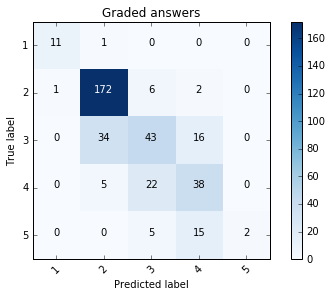

In [18]:
#From scikit's user guide

# Compute confusion matrix
cnf_matrix = confusion_matrix(dev_set.KIScore, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Graded answers')

In [29]:
# Cross validation for checking final classifier

from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import KFold

# Get sizes of training and test sets
rows, columns = df.shape

kf = KFold(rows, 10, shuffle=True)
avg_accuracy = 0
count = 1
for train_indices, test_indices in kf:
    train_set = df.loc[train_indices] 
    dev_set = df.loc[test_indices] 
    
    pipeline_p = pipeline2.fit(train_set['Answer'], 
                                  train_set.KIScore)
    
    trial_predictions = pipeline_p.predict(dev_set["Answer"])
    accuracy = accuracy_score(dev_set.KIScore, trial_predictions)
    print(count,": ",accuracy)
    avg_accuracy += accuracy_score(dev_set.KIScore, trial_predictions)
    count = count + 1
print("Average:",(avg_accuracy/10))

1 :  0.75935828877
2 :  0.705882352941
3 :  0.716577540107
4 :  0.705882352941
5 :  0.711229946524
6 :  0.705882352941
7 :  0.752688172043
8 :  0.736559139785
9 :  0.725806451613
10 :  0.731182795699
Average: 0.725104939336


Lets break the answers by confidence.

This was just something I was working with at the end. Considering that I had peaked in terms of accuracy across the set, I decided to implement something that would grade only those questions on which the classifier had the most confidence. For example, in the below code, the classifier only classifies answers if there is a certain category has at least a 0.8 probability of being correct. Once this is done, I see a higher accuracy rating. The though behind this was that I could with a very high accuracy predict at a large portion of the answers, but would leave some answers for manual grading in which the classification might turn out to be erroneous.

In [19]:
probab = p_predictor.predict_proba(dev_set['Answer'].values)
count = 0
conf = pd.DataFrame()
uncern = pd.DataFrame()
for i in range(0, len(probab)):
    filt = list(filter(lambda x: x > 0.68, probab[i]))
    if len(filt) > 0:
        df1 = pd.DataFrame([list(dev_set.ix[i])], columns = ['WISEID', 'Answer', 'KIScore'])
        #print(df1)
        conf = conf.append(df1)
    else:
        df1 = pd.DataFrame([list(dev_set.ix[i])], columns = ['WISEID', 'Answer', 'KIScore'])
        uncern = uncern.append(df1)

In [20]:
predicted_ch = p_predictor.predict(conf['Answer'].values)
accuracy_score(conf.KIScore, predicted_ch)

0.85135135135135132

In [21]:
cohen_kappa_score(conf.KIScore, predicted_ch)

0.59143382968044178

Confusion matrix, without normalization
[[ 10   1   0   0   0]
 [  0 162   0   0   0]
 [  0  24  14   0   0]
 [  0   1   5   2   0]
 [  0   0   1   1   1]]


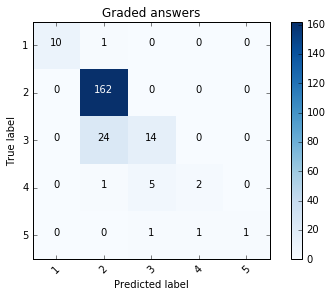

In [22]:
cnf_matrix = confusion_matrix(conf.KIScore, predicted_ch)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Graded answers')

In [23]:
uncern.to_csv('Manual_Grading.csv' , index = False)
conf.to_csv('Graded.csv' , index = False)

Adding Code for summarising responses

Starting with lesk if I need it.

In [109]:
def compare_overlaps_greedy(context, synsets_signatures, pos=None):
    """
    Calculate overlaps between the context sentence and the synset_signature
    and returns the synset with the highest overlap.
    
    :param context: ``context_sentence`` The context sentence where the ambiguous word occurs.
    :param synsets_signatures: ``dictionary`` A list of words that 'signifies' the ambiguous word.
    :param pos: ``pos`` A specified Part-of-Speech (POS).
    :return: ``lesk_sense`` The Synset() object with the highest signature overlaps.
    """
    max_overlaps = 0
    lesk_sense = None
    for ss in synsets_signatures:
        if pos and str(ss.pos()) != pos: # Skips different POS.
            continue
        overlaps = set(synsets_signatures[ss]).intersection(context)
        #print(overlaps)
        if len(overlaps) > max_overlaps:
            lesk_sense = ss
            max_overlaps = len(overlaps)  
    return lesk_sense

In [110]:
def lesk(context_sentence, ambiguous_word, pos=None, dictionary=None):
    """
    This function is the implementation of the original Lesk algorithm (1986).
    It requires a dictionary which contains the definition of the different
    sense of each word. See http://goo.gl/8TB15w

        >>> from nltk import word_tokenize
        >>> sent = word_tokenize("I went to the bank to deposit money.")
        >>> word = "bank"
        >>> pos = "n"
        >>> lesk(sent, word, pos)
        Synset('bank.n.07')
    
    :param context_sentence: The context sentence where the ambiguous word occurs.
    :param ambiguous_word: The ambiguous word that requires WSD.
    :param pos: A specified Part-of-Speech (POS).
    :param dictionary: A list of words that 'signifies' the ambiguous word.
    :return: ``lesk_sense`` The Synset() object with the highest signature overlaps.
    """
    if not dictionary:
        #print("here")
        dictionary = {}
        for ss in wn.synsets(ambiguous_word):
            #print(ss)
            #print(ss.pos())
            #print(ss.definition().split())
            dictionary[ss] = ss.definition().split()
    best_sense = compare_overlaps_greedy(context_sentence, dictionary, pos)
    return best_sense


In [174]:
pos_tags = {'NN' : 'n',
           'NNS' : 'n',
           'NNP' : 'n',
           'NNPS' : 'n',
           'JJ' : 'a',
           'JJR' : 'a',
           'JJS' : 'a',
           'VB' : 'v',
           'VBD' : 'v',
           'VBG' : 'v',
           'VBN' : 'v',
           'VBZ' : 'v',
           'VBP' : 'v'}

from collections import defaultdict
def freq_normed_unigrams(sents):
    wnl = WordNetLemmatizer() # to get word stems
    
    #print(sents)
    tagged_POS_sents = [nltk.pos_tag(word_tokenize(sent)) for sent in sents] # tags sents
    
    print(tagged_POS_sents)
    
    normed_tagged_words = [wnl.lemmatize(word[0].lower()) for sent in tagged_POS_sents
                           for word in sent 
                           if word[0].lower() not in nltk.corpus.stopwords.words('english')
                           and word[0] not in punctuation # remove punctuation
                           and not re.search(r'''^[\.,;"'?!():\-_`]+$''', word[0])
                           and (word[1].startswith('N') or word[1].startswith('J')
                                or word[1].startswith('V'))]  # include only nouns
    #print(normed_tagged_words)

    top_normed_unigrams = [word for (word, count) in nltk.FreqDist(normed_tagged_words).most_common(15)]
    print(top_normed_unigrams)
    return top_normed_unigrams

def categories_from_hypernyms(sents):
    termlist = freq_normed_unigrams(sents) # get top unigrams
    hypterms = []
    hypterms_dict = defaultdict(list)
    for term in termlist:                  # for each term
        s = wn.synsets(term.lower(), 'n')  # get its nominal synsets
        wn_tag = pos_tags.get(nltk.pos_tag([term])[0][1], 'n')
        sn = lesk(sents[0], term, wn_tag)
        #print("****")
        #print(term)
        #print(wn_tag)
        for syn in [sn]:
            if syn is not None:
                for hyp in syn.hypernyms():    # It has a list of hypernyms
                    hypterms = hypterms + [hyp.name]      # Extract the hypernym name and add to list
                    hypterms_dict[hyp.name].append(term)  # Extract examples and add them to dict
    hypfd = nltk.FreqDist(hypterms)             # After going through all the nouns, print out the hypernyms 
    for (name, count) in hypfd.most_common(400):  # that have accumulated the most counts (have seen the most descendents)
        print( name(), '({0})'.format(count))
        print ('\t', ', '.join(set(hypterms_dict[name])))  # show the children found for each hypernym
        print ()

In [175]:
from string import punctuation

sent = "I chose using a light-colored paint on the outside, and a light-colored fabric on the inside because light colors reflect the light which makes it cooler, and dark colors absorb all the light, which makes it hotter."

#tagged = nltk.pos_tag(word_tokenize(sent)) 

In [176]:
categories_from_hypernyms([sent])

[[('I', 'PRP'), ('chose', 'VBD'), ('using', 'VBG'), ('a', 'DT'), ('light-colored', 'JJ'), ('paint', 'NN'), ('on', 'IN'), ('the', 'DT'), ('outside', 'NN'), (',', ','), ('and', 'CC'), ('a', 'DT'), ('light-colored', 'JJ'), ('fabric', 'NN'), ('on', 'IN'), ('the', 'DT'), ('inside', 'NN'), ('because', 'IN'), ('light', 'JJ'), ('colors', 'NNS'), ('reflect', 'VBP'), ('the', 'DT'), ('light', 'NN'), ('which', 'WDT'), ('makes', 'VBZ'), ('it', 'PRP'), ('cooler', 'JJR'), (',', ','), ('and', 'CC'), ('dark', 'JJ'), ('colors', 'NNS'), ('absorb', 'VBP'), ('all', 'PDT'), ('the', 'DT'), ('light', 'NN'), (',', ','), ('which', 'WDT'), ('makes', 'VBZ'), ('it', 'PRP'), ('hotter', 'RBR'), ('.', '.')]]
['light', 'light-colored', 'color', 'make', 'chose', 'outside', 'paint', 'using', 'inside', 'fabric', 'reflect', 'cooler', 'dark', 'absorb']
ethical_motive.n.01 (1)
	 light

makeup.n.01 (1)
	 paint

achieve.v.01 (1)
	 make

refrigerator.n.01 (1)
	 cooler

race.n.03 (1)
	 color



In [117]:
nltk.pos_tag(word_tokenize(sent))

[('I', 'PRP'),
 ('chose', 'VBD'),
 ('using', 'VBG'),
 ('a', 'DT'),
 ('light-colored', 'JJ'),
 ('paint', 'NN'),
 ('on', 'IN'),
 ('the', 'DT'),
 ('outside', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('a', 'DT'),
 ('light-colored', 'JJ'),
 ('fabric', 'NN'),
 ('on', 'IN'),
 ('the', 'DT'),
 ('inside', 'NN'),
 ('because', 'IN'),
 ('light', 'JJ'),
 ('colors', 'NNS'),
 ('reflect', 'VBP'),
 ('the', 'DT'),
 ('light', 'NN'),
 ('which', 'WDT'),
 ('makes', 'VBZ'),
 ('it', 'PRP'),
 ('cooler', 'JJR'),
 (',', ','),
 ('and', 'CC'),
 ('dark', 'JJ'),
 ('colors', 'NNS'),
 ('absorb', 'VBP'),
 ('all', 'PDT'),
 ('the', 'DT'),
 ('light', 'NN'),
 (',', ','),
 ('which', 'WDT'),
 ('makes', 'VBZ'),
 ('it', 'PRP'),
 ('hotter', 'RBR'),
 ('.', '.')]